/opt/homebrew/Cellar/micromamba/2.0.8/envs/bmwTeam/lib/python3.13/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


New best model saved at epoch 1 with val loss: 0.4148
Epoch 1/300, Train Loss: 0.4644, Val Loss: 0.4148
New best model saved at epoch 2 with val loss: 0.3391
Epoch 2/300, Train Loss: 0.3998, Val Loss: 0.3391
New best model saved at epoch 3 with val loss: 0.3255
Epoch 3/300, Train Loss: 0.3712, Val Loss: 0.3255
New best model saved at epoch 4 with val loss: 0.3148
Epoch 4/300, Train Loss: 0.3450, Val Loss: 0.3148
New best model saved at epoch 5 with val loss: 0.2802
Epoch 5/300, Train Loss: 0.3301, Val Loss: 0.2802
New best model saved at epoch 6 with val loss: 0.2788
Epoch 6/300, Train Loss: 0.3147, Val Loss: 0.2788
New best model saved at epoch 7 with val loss: 0.2473
Epoch 7/300, Train Loss: 0.3065, Val Loss: 0.2473
New best model saved at epoch 8 with val loss: 0.2423
Epoch 8/300, Train Loss: 0.2957, Val Loss: 0.2423
New best model saved at epoch 9 with val loss: 0.2179
Epoch 9/300, Train Loss: 0.2871, Val Loss: 0.2179
Epoch 10/300, Train Loss: 0.2834, Val Loss: 0.2283
Epoch 11/300,

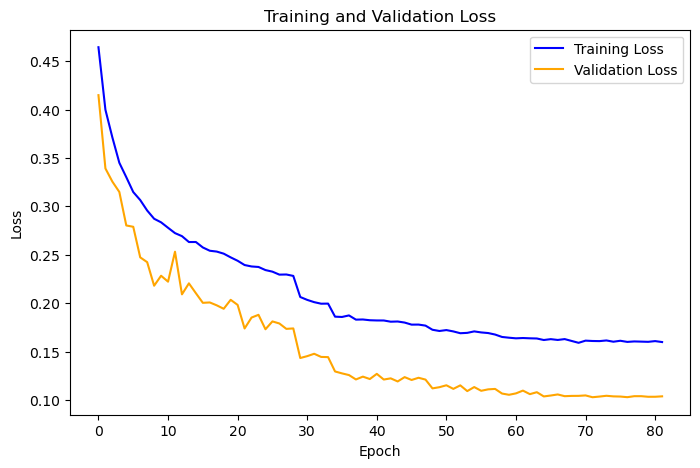

Test accuracy (with best model): 0.9663


In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import os
import sys 
from maze_env import PolicyNetwork

# Set device to MPS for Mac users, otherwise CPU
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

# Load the preference dataset
df_preferences = pd.read_parquet("../tests/preferences.parquet")

# --- Split the dataset into train (90%), val (5%), and test (5%) ---
train_df = df_preferences.sample(frac=0.90, random_state=42)
temp_df = df_preferences.drop(train_df.index)
val_df = temp_df.sample(frac=0.50, random_state=42)
test_df = temp_df.drop(val_df.index)

# Define the Preference Dataset class
class PreferenceDataset(Dataset):
    def __init__(self, df):
        # --- all'interno di PreferenceDataset --------------------
        norm_stats_path = "../tests/norm_stats.npz" # Adatta il path se necessario
        norm = np.load(norm_stats_path)
        mean = norm["mean"].astype(np.float32)
        std  = norm["std"].astype(np.float32) + 1e-8 # Aggiungi epsilon
        self.x_better = ((df[["x_better","y_better"]].values - mean) / std).astype(np.float32)
        self.x_worse  = ((df[["x_worse", "y_worse"] ].values - mean) / std).astype(np.float32)
        self.labels = df["preference"].values
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return (
            torch.tensor(self.x_better[idx], dtype=torch.float32),
            torch.tensor(self.x_worse[idx], dtype=torch.float32),
            torch.tensor(self.labels[idx], dtype=torch.float32)
        )

# DPO loss function
def dpo_loss(model, x_better, x_worse):
    r_better = model(x_better)
    r_worse = model(x_worse)
    return -torch.mean(torch.log(torch.sigmoid(r_better - r_worse)))

# Training parameters
batch_size = 128
epochs = 300
learning_rate = 1e-3
hidden_dim = 256
num_layers = 4
dropout_prob = 0.05

# Early stopping parameter
early_stopping_patience = 10  # Number of epochs to wait before stopping if no improvement

# Create Dataset objects for train, val, and test
train_dataset = PreferenceDataset(train_df)
val_dataset = PreferenceDataset(val_df)
test_dataset = PreferenceDataset(test_df)

# Create DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Initialize model, optimizer, and scheduler
model = PolicyNetwork(
    hidden_dim=hidden_dim,
    num_layers=num_layers,
    dropout_prob=dropout_prob
).to(device)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=3, verbose=True
)

# Track best validation loss for saving best model
best_val_loss = float('inf')
no_improvement_count = 0  # Tracks epochs without improvement

# Lists to store losses per epoch
train_losses = []
val_losses = []

# Training loop
for epoch in range(epochs):
    # --- Training Phase ---
    model.train()
    epoch_train_loss = 0.0
    for x_better, x_worse, _ in train_dataloader:
        x_better, x_worse = x_better.to(device), x_worse.to(device)
        optimizer.zero_grad()
        loss = dpo_loss(model, x_better, x_worse)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()
    
    avg_train_loss = epoch_train_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)

    # --- Validation Phase ---
    model.eval()
    epoch_val_loss = 0.0
    with torch.no_grad():
        for x_better, x_worse, _ in val_dataloader:
            x_better, x_worse = x_better.to(device), x_worse.to(device)
            loss = dpo_loss(model, x_better, x_worse)
            epoch_val_loss += loss.item()
    avg_val_loss = epoch_val_loss / len(val_dataloader)
    val_losses.append(avg_val_loss)

    # Step the scheduler with the validation loss
    scheduler.step(avg_val_loss)

    # Check if this is the best validation loss so far; if so, save the model and reset patience
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), "best_dpo_policy.pth")
        print(f"New best model saved at epoch {epoch+1} with val loss: {avg_val_loss:.4f}")
        no_improvement_count = 0
    else:
        no_improvement_count += 1

    print(f"Epoch {epoch+1}/{epochs}, "
          f"Train Loss: {avg_train_loss:.4f}, "
          f"Val Loss: {avg_val_loss:.4f}")

    # Early stopping check
    if no_improvement_count >= early_stopping_patience:
        print(f"Early stopping triggered at epoch {epoch+1}.")
        break

# --- Plot losses ---
plt.figure(figsize=(8,5))
plt.plot(train_losses, label="Training Loss", color="blue")
plt.plot(val_losses, label="Validation Loss", color="orange")
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# ------------------
# --- Test Phase ---
# ------------------

# Load the best saved model
model.load_state_dict(torch.load("best_dpo_policy.pth"))
model.to(device)
model.eval()

correct = 0
total = 0
with torch.no_grad():
    for x_better, x_worse, _ in test_dataloader:
        x_better, x_worse = x_better.to(device), x_worse.to(device)
        r_better = model(x_better)
        r_worse = model(x_worse)
        # We consider the prediction correct if r_better > r_worse
        correct += torch.sum(r_better > r_worse).item()
        total += x_better.size(0)

test_accuracy = correct / total
print(f"Test accuracy (with best model): {test_accuracy:.4f}")

In [2]:
states = torch.rand(256, 2, device=device)
with torch.no_grad():
    v = model(states).cpu().numpy().squeeze()
print("value range:", v.min(), v.max())


value range: -18.616693 19.90505
